# 3.11 模型选择、欠拟合和过拟合
## 3.11.4 多项式函数拟合实验

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

1.9.1


### 3.11.4.1 生成数据集

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)  #在列维相加
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [7]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-1.2678],
         [-1.4017]]),
 tensor([[-1.2678,  1.6074, -2.0379],
         [-1.4017,  1.9649, -2.7543]]),
 tensor([-13.3931, -18.7718]))

### 3.11.4.2 定义、训练和测试模型

In [8]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [9]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

### 3.11.4.3 三阶多项式函数拟合（正常）

final epoch: train loss 0.00033918407279998064 test loss 0.0009671484003774822
weight: tensor([[ 1.1663, -3.3901,  5.6112]]) 
bias: tensor([4.9934])


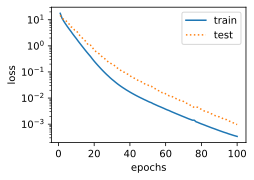

In [10]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

### 3.11.4.4 线性函数拟合（欠拟合）

final epoch: train loss 119.21467590332031 test loss 125.8681640625
weight: tensor([[15.8462]]) 
bias: tensor([2.0923])


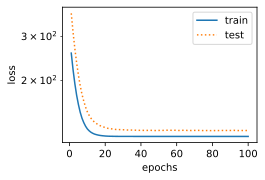

In [11]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

### 3.11.4.5 训练样本不足（过拟合）

final epoch: train loss 0.7909131050109863 test loss 77.47657775878906
weight: tensor([[ 2.0385, -2.6274,  3.3478]]) 
bias: tensor([-0.7428])


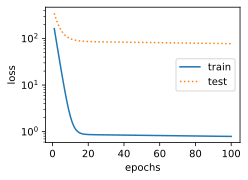

In [12]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

# 3.13 丢弃层 dropout layer
丢弃法不改变输入的期望值
由于在训练中隐藏层神经元的丢弃是随机的，即所有隐藏层都有可能被清零，输出层的计算⽆法过度依赖 中的任⼀个，从⽽在训练模型时起到正则化的作⽤，并可以⽤来应对过拟合。

In [17]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

def dropout(X,drop_prob):
    X= X.float()
    assert 0 <=drop_prob <=1
    keep_prob = 1 - drop_prob
    # 以下情况丢弃全部元素
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.randn(X.shape) <keep_prob).float()
    
    return mask *X /keep_prob

In [18]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [19]:
dropout(X, 0.5)

tensor([[ 0.,  0.,  0.,  6.,  8.,  0.,  0., 14.],
        [ 0., 18., 20., 22.,  0., 26., 28.,  0.]])

In [20]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [21]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256,256


W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs,num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1,num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2,num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

下⾯定义的模型将全连接层和激活函数ReLU串起来，并对每个激活函数的输出使⽤丢弃法。我们可以分别设置各个层的丢弃概率。通常的建议是把靠近输⼊层的丢弃概率设得⼩⼀点。在这个实验中，我们把第⼀个隐藏层的丢弃概率设为 0.2 ，把第⼆个隐藏层的丢弃概率设为 0.5 。

In [22]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X,is_training = True):
    X = X.view(-1,num_inputs)
    H1 = (torch.matmul(X,W1) +b1).relu()
    if is_training:
        H1 = dropout(H1,drop_prob1)
    H2 =  (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2,W3) + b3

In [25]:
# 需要修改evaluate_accuracy
def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0,0
    for X,y in data_iter:
        if isinstance(net,torch.nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim =1) == y).float().sum().item()
            net.train() # 改回训练模式
        else:
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X,is_training = False).argmax(dim=1)==y).float().sum().item()
            else:
                acc_sum +=(net(X).argmax(dim=1)==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

In [26]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
    batch_size, params, lr)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\xuwh/Datasets/FashionMNIST\FashionMNIST\raw



D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


epoch 1, loss 0.0043, train acc 0.573, test acc 0.763
epoch 2, loss 0.0022, train acc 0.790, test acc 0.815
epoch 3, loss 0.0019, train acc 0.825, test acc 0.824
epoch 4, loss 0.0017, train acc 0.841, test acc 0.844
epoch 5, loss 0.0016, train acc 0.850, test acc 0.832


In [27]:
net = nn.Sequential(
     d2l.FlattenLayer(),
     nn.Linear(num_inputs, num_hiddens1),
     nn.ReLU(),
     nn.Dropout(drop_prob1),
     nn.Linear(num_hiddens1, num_hiddens2),
     nn.ReLU(),
     nn.Dropout(drop_prob2),
     nn.Linear(num_hiddens2, 10)
 )
for param in net.parameters():
     nn.init.normal_(param, mean=0, std=0.01)

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
    batch_size, None, None, optimizer)

epoch 1, loss 0.0045, train acc 0.556, test acc 0.729
epoch 2, loss 0.0023, train acc 0.784, test acc 0.729
epoch 3, loss 0.0019, train acc 0.820, test acc 0.833
epoch 4, loss 0.0018, train acc 0.837, test acc 0.820
epoch 5, loss 0.0016, train acc 0.848, test acc 0.821


In [28]:
pip install pandas


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.9.1


In [2]:
train_data = pd.read_csv('../../data/kaggle_house/train.csv')
test_data = pd.read_csv('../../data/kaggle_house/test.csv')

In [4]:
train_data.shape,test_data.shape,train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

((1460, 81),
 (1459, 80),
    Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
 0   1          60       RL         65.0       WD        Normal     208500
 1   2          20       RL         80.0       WD        Normal     181500
 2   3          60       RL         68.0       WD        Normal     223500
 3   4          70       RL         60.0       WD       Abnorml     140000)

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1],test_data.iloc[:, 1:]))

In [9]:
numeric_features = all_features.dtypes[all_features.dtypes !='object'].index
all_features[numeric_features] =all_features[numeric_features].apply(
     lambda x: (x - x.mean()) / (x.std()))

# 标准化后 每个特征的均值变为0 我们可以直接用0来代替缺失值
all_features = all_features.fillna(0) # fillna = fill nan

In [10]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # (2919, 354)

(2919, 354)

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
    dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,
    dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,
    dtype=torch.float).view(-1, 1)


array([[ 0.06731988, -0.18444262, -0.21784137, ...,  1.        ,
         0.        ,  0.        ],
       [-0.87346638,  0.45809588, -0.07203174, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988, -0.05593492,  0.13717338, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.30251644, -0.14160672, -0.14278111, ...,  1.        ,
         0.        ,  0.        ],
       [-0.87346638, -0.05593492, -0.0571972 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.87346638,  0.24391638, -0.02930318, ...,  1.        ,
         0.        ,  0.        ]])

In [12]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [13]:
def log_rmse(net, features, labels):
     with torch.no_grad():
         # 将⼩于1的值设成1，使得取对数时数值更稳定
         clipped_preds = torch.max(net(features), torch.tensor(1.0))
         rmse = torch.sqrt(2 * loss(clipped_preds.log(),
labels.log()).mean())
     return rmse.item()